In [58]:
### IMPORTS ###
import os, glob, re, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # KNN c
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from catboost import CatBoostClassifier

## Evaluation
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [59]:
### GLOBAL VARIABLES ###
RAND_STATE = 0
N_FOLDS = 5

### FUNCTIONS ###
def getPredictions(X):
    """ Converts probabilities in df to labels
    Args:
        X (dataframe): Columns correponds to probabilities of different models
    Returns:
        dataframe: Predicted labels (0 or 1)
    """
    predictions = np.zeros(X.shape)
    predictions[X > 0.5] = 1
    return pd.DataFrame(predictions, columns=list(X))
  
def calcNCombinations(params_grid):
    '''Calculates number of all possible combinations'''
    list_lengths = [len(x) for x in params_grid.values()]
    return np.prod(list_lengths)
  
def runRandSearchCV(model, params_grid, params_search,
                    X_alltrain, y_alltrain, filename, params_fit={}):
    '''Run randomized cross-validation grid search and pickle best parameters'''
    
    print("Number of all possible combinations:",
          calcNCombinations(params_grid))

    # Random search of parameters across n_iter different
    # combinations using all available cores
    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_grid,
        n_jobs=-1,
        **params_search
    )
    
    start_time = time.time()
    grid_search.fit(X_alltrain, y_alltrain, **params_fit) # Grid search fit!
    elapsed_time = time.time() - start_time
    print("Model fit duration:",
          time.strftime("%H h %M min %S s", time.gmtime(elapsed_time)))
    
    params_wpath = os.path.join("dump/params/", filename)
    print("Saved grid search results to: {}\n".format(params_wpath))
    with open(params_wpath, "wb") as f:
        pkl.dump(grid_search.cv_results_, f)
        
    return grid_search.cv_results_

def getGridSearchParams(filename):
    params_path = os.path.join("dump/params/", filename)
    with open(params_path, "rb") as f:
        results_dict = pkl.load(f)
    results = pd.DataFrame(results_dict)
    
    # Best params (Accuracy)
    idx_acc = results.mean_test_accuracy.idxmax()
    print("Best params (Accuracy): {}".format(results.params[idx_acc]))
    print("Training accuracy: {:.3f} +/- {:.3f}%".format(
        results.mean_train_accuracy[idx_acc]*100,
        results.std_train_accuracy[idx_acc]*100))
    print("Validation accuracy: {:.3f} +/- {:.3f}%\n".format(
        results.mean_test_accuracy[idx_acc]*100,
        results.std_test_accuracy[idx_acc]*100))

    # Best params (F1)
    idx_f1 = results.mean_test_f1.idxmax()
    print("Best params (F1): {}".format(results.params[idx_f1]))
    print("Training F1: {:.3f} +/- {:.3f}%".format(
        results.mean_train_f1[idx_f1]*100,
        results.std_train_f1[idx_f1]*100))
    print("Validation F1: {:.3f} +/- {:.3f}%".format(
        results.mean_test_f1[idx_f1]*100,
        results.std_test_f1[idx_f1]*100))
    print("Training accuracy: {:.3f} +/- {:.3f}%".format(
        results.mean_train_accuracy[idx_f1]*100,
        results.std_train_accuracy[idx_f1]*100))
    print("Validation accuracy: {:.3f} +/- {:.3f}%\n".format(
        results.mean_test_accuracy[idx_f1]*100,
        results.std_test_accuracy[idx_f1]*100))
    
    return (results.params[idx_acc], results.params[idx_f1], results)

def runL1ModelCV(model, X_alltrain, y_alltrain, X_test=None,
                 cv_filename=None, submission_filename=None,
                 best_threshold=False, n_folds=N_FOLDS, random_state=RAND_STATE,
                 **kwargs):
    '''Performs cross-validation on L1 model to 
    2) determine optimal prediction threshold 3) return CV metrics 4) predict test set
    
    Does not perform early_stopping_rounds when trained with entire training dataset!
    '''
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=False)
#     skf = StratifiedKFold(n_splits=n_folds, shuffle=True,
#                           random_state=random_state)
    
    list_thresholds = []
    list_accs = []
    list_ypred_train = []
    list_y_train = []
    list_ypred_vld = []
    list_y_vld = []
    p_alltrain = np.zeros(X_alltrain.shape[0]) # Initialise probabilties
    for i, (train_idx, vld_idx) in enumerate(skf.split(X_alltrain, y_alltrain)):
        print("#"*10)
        print("Fold", i)
        print("#"*10)
        X_train = X_alltrain.iloc[train_idx,:]
        y_train = y_alltrain.iloc[train_idx]
        X_vld = X_alltrain.iloc[vld_idx,:]
        y_vld = y_alltrain.iloc[vld_idx]
        
        model.fit(X_train, y_train, **kwargs)
        
        # MODEL PREDICT
        p_train = model.predict_proba(X_train)[:,1]
        ypred_train = (p_train > 0.5).astype(int)

        p_vld = model.predict_proba(X_vld)[:,1]
        ypred_vld = (p_vld > 0.5).astype(int)
        
        p_alltrain[vld_idx] = p_vld # Save proba from validation fold
        
        # Appending to list
        list_y_train.append(y_train)
        list_ypred_train.append(ypred_train)
        list_y_vld.append(y_vld)
        list_ypred_vld.append(ypred_vld)
        
        print("Train set:")
        print(confusion_matrix(y_train, ypred_train))
        print("Accuracy = {:.3f}, F1 = {:.3f}".format(
            accuracy_score(y_train, ypred_train)*100,
            f1_score(y_train, ypred_train)*100))

        print("Validation set:")
        print(confusion_matrix(y_vld, ypred_vld))
        print("Accuracy = {:.3f}, F1 = {:.3f}".format(
            accuracy_score(y_vld, ypred_vld)*100,
            f1_score(y_vld, ypred_vld)*100))
    
        if best_threshold == True:
            # Search for best threshold in current fold
            threshold, acc = searchThreshold(p_vld, y_vld)
            list_thresholds.append(threshold)
            list_accs.append(acc)
    
    # k-fold cross validation results
    cv_list = [list_y_train, list_ypred_train,
               list_y_vld, list_ypred_vld]
    pkl_obj = [cv_list, p_alltrain]
        
    if X_test is not None:
        # Prediction of test set with model fitted on entire training set
        # MODEL FIT: TEST
        model.fit(X_alltrain, y_alltrain, **kwargs)
        
        # MODEL PREDICT: TEST
        p_test = model.predict_proba(X_test)[:,1]
        pkl_obj.append(p_test) # Return p_test
        ypred_test = (p_test > 0.5).astype(int)
        
        if best_threshold == True:
            mean_threshold = np.mean(list_thresholds)
            ypred_threshold_test = (p_test > mean_threshold).astype(int)
            # Prediction based on best threshold
            print("\nFinal threshold = {:.5f}".format(mean_threshold))
    
        # SAVE FILE
        if submission_filename is not None:
            print("Predictions:")
            saveResult(ypred_test, submission_filename)
            
            if best_threshold == True:
                # Save predictions with best threshold
                submission_threshold_filename = submission_filename + '.csv'
                saveResult(ypred_threshold_test,
                           submission_threshold_filename)

    if cv_filename is not None:
        # Pickles cross validation predictions
        cv_path = os.path.join("dump/log/", cv_filename)
        print("Saving CV predictions to: {}\n".format(cv_path))
        with open(cv_path, "wb") as f:
            pkl.dump(cv_list, f)
    
    return pkl_obj # [cv_list, p_alltrain, p_test]

def printCVResults(filename):
    cv_path = os.path.join("dump/log/", filename)
    with open(cv_path, "rb") as f:
        list_list = pkl.load(f)
        # [list_y_train, list_ypred_train
        # list_y_vld, list_ypred_vld]

    train_acc = []
    vld_acc = []
    train_f1 = []
    vld_f1 = []
    for y_train, ypred_train, y_vld, ypred_vld in zip(*list_list):
        print("Train set:")
        print(confusion_matrix(y_train, ypred_train))
        print("Accuracy = {:.5f}, F1 = {:.5f}".format(
            accuracy_score(y_train, ypred_train),
            f1_score(y_train, ypred_train)))

        print("Validation set:")
        print(confusion_matrix(y_vld, ypred_vld))
        print("Accuracy = {:.5f}, F1 = {:.5f}\n".format(
            accuracy_score(y_vld, ypred_vld),
            f1_score(y_vld, ypred_vld)))    

        train_acc.append(accuracy_score(y_train, ypred_train))
        vld_acc.append(accuracy_score(y_vld, ypred_vld))
        train_f1.append(f1_score(y_train, ypred_train))
        vld_f1.append(f1_score(y_vld, ypred_vld))

    mean_train_acc = np.mean(train_acc)
    std_train_acc = np.std(train_acc)
    mean_vld_acc = np.mean(vld_acc)
    std_vld_acc = np.std(vld_acc)
    
    mean_train_f1 = np.mean(train_f1)
    std_train_f1 = np.std(train_f1)
    mean_vld_f1 = np.mean(vld_f1)
    std_vld_f1 = np.std(vld_f1)
    
    print(cv_path)
    print("Training accuracy: {:.2f} +/- {:.2f}%".format(
        mean_train_acc*100, std_train_acc*100))
    print("Validation accuracy: {:.2f} +/- {:.2f}%".format(
        mean_vld_acc*100, std_vld_acc*100))
    print("Training F1: {:.4f} +/- {:.4f}%".format(
        mean_train_f1, std_train_f1))
    print("Validation F1: {:.4f} +/- {:.4f}%\n".format(
        mean_vld_f1, std_vld_f1))

def searchThreshold(p, y):
    # Search for threshold that maximises accuracy
    # No assumption of convexity in (f: threshold -> acc)
    
    p = pd.Series(p) # Explicit type conversion to pd.Series
    p_subset = p[(0.3 < p) & (p < 0.7)].sort_values()
    
    def calcAcc(threshold):
        # Nonlocals: p and y
        ypred_threshold = (p > threshold).astype(int)
        return accuracy_score(y, ypred_threshold)
    
    list_acc = [calcAcc(x) for x in p_subset]
    
    max_threshold = p_subset.iloc[np.argmax(list_acc)]
    max_acc = np.max(list_acc)
    
    print("Best threshold: {:.4f} (Accuracy = {:.2f})".format(
        max_threshold, max_acc*100))
    
    fig, ax = plt.subplots()
    ax.plot(p_subset, list_acc)
    ax.scatter(max_threshold, max_acc, c='orange')
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Accuracy")
    plt.show()

    return max_threshold, max_acc

def plotROC(p, y):    
    fpr, tpr, threshold = roc_curve(y, p, drop_intermediate=True)
    AUC = auc(fpr, tpr)
    
    max_threshold, max_accuracy = searchThreshold(p, y)
    
    # Plot ROC curve
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    lab = "ROC (AUC: {:.3f})".format(AUC)
    ax.plot(fpr, tpr, label=lab)
    ax.scatter(fpr[threshold == max_threshold],
               tpr[threshold == max_threshold])
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

    return fig

def saveResult(ypred_test, filename):
    '''Saves predicted labels to csv file'''
    # Size of test set is 24421
    assert ypred_test.size == 24421
    results_dict = {
        "id": np.arange(1, ypred_test.size + 1),
        "prediction": ypred_test
    }
    results = pd.DataFrame(results_dict)
    
    path = os.path.join("dump/submissions/", filename)
    print("Saved submission file to:", path)
    results.to_csv(path, index=False)   

def saveL1Test(model, X_alltrain, y_alltrain, X_test, filename):
    model.fit(X_alltrain, y_alltrain)
    ypred_test = model.predict(X_test)
    saveResult(ypred_test, filename)

In [60]:
## Import PCA2 data
L1_WPATH1 = "dump/data/pca2.pkl"
with open(L1_WPATH1, "rb") as f:
    pca_alltrain, y_alltrain, pca_test = pkl.load(f)
print(pca_alltrain.shape)
print(pca_test.shape)

(24421, 10)
(24421, 10)


### Import model probabilities

In [61]:
RDIR = "dump/proba/stack2/*"
list_files = glob.glob(RDIR)
list_files.sort()

model_names = [re.search(".*/(.*).pkl", rpath).group(1)
               for rpath in list_files]
print(model_names)
allp_alltrain = pd.DataFrame(columns=model_names)
allp_test = pd.DataFrame(columns=model_names)

# Concatenate all probabilities to form dataframe
for rpath, name in zip(list_files, model_names):
    with open(rpath, "rb") as f:
        p_alltrain, p_test = pkl.load(f)
    allp_alltrain[name] = p_alltrain
    allp_test[name] = p_test
    
print(allp_alltrain.shape)
print(allp_test.shape)
allp_alltrain.head()

['allcat_catnb', 'nopp_et1', 'nopp_et2', 'nopp_lgbm1', 'nopp_lgbm2', 'nopp_rf1', 'nopp_rf2', 'nopp_xgb1', 'nopp_xgb2', 'pca1_svm1', 'pca1_svm2', 'pca2_mlp', 'raw1_catboost3', 'raw1_catboost4', 'wxpp1c_knn']
(24421, 15)
(24421, 15)


,allcat_catnb,nopp_et1,nopp_et2,nopp_lgbm1,nopp_lgbm2,nopp_rf1,nopp_rf2,nopp_xgb1,nopp_xgb2,pca1_svm1,pca1_svm2,pca2_mlp,raw1_catboost3,raw1_catboost4,wxpp1c_knn
0,0.000008,0.003490,0.011138,0.007373,0.012520,0.004021,0.019573,0.006871,0.009343,0.078474,0.034886,0.002066,0.001551,0.003613,0.000000
1,0.140076,0.190204,0.388747,0.222139,0.414929,0.196942,0.339165,0.187417,0.265594,0.097510,0.032696,0.074069,0.195918,0.286531,0.190476
2,0.076471,0.235879,0.471053,0.185988,0.383326,0.195644,0.302336,0.202298,0.293016,0.085101,0.070599,0.138156,0.214006,0.298474,0.238095
3,0.949461,0.685143,0.876671,0.715717,0.865494,0.731873,0.899054,0.661633,0.745233,0.765356,0.598961,0.660393,0.641380,0.749714,0.619048
4,0.989046,0.645199,0.832020,0.842712,0.991549,0.872873,0.947814,0.819060,0.856521,0.789121,0.737510,0.902369,0.985751,0.990567,1.000000


### Concatenate features and model outputs

In [62]:
pc_idx = ['PC' + str(x) for x in list(range(1,11))]
## Concatenate model outputs and data features
X_alltrain = pd.DataFrame(np.hstack([allp_alltrain, pca_alltrain]),
                          columns=list(allp_alltrain) + pc_idx)
X_test = pd.DataFrame(np.hstack([allp_test, pca_test]),
                      columns=list(allp_alltrain) + pc_idx)
print(X_alltrain.shape)
print(X_test.shape)
X_alltrain

(24421, 25)
(24421, 25)


,allcat_catnb,nopp_et1,nopp_et2,nopp_lgbm1,nopp_lgbm2,nopp_rf1,nopp_rf2,nopp_xgb1,nopp_xgb2,pca1_svm1,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.000008,0.003490,0.011138,0.007373,0.012520,0.004021,0.019573,0.006871,0.009343,0.078474,...,-1.521918,0.515021,0.482417,-0.238125,0.154951,-0.303196,-0.106651,0.833078,0.035520,-0.007958
1,0.140076,0.190204,0.388747,0.222139,0.414929,0.196942,0.339165,0.187417,0.265594,0.097510,...,0.888643,0.076789,0.569358,-1.604776,1.533522,0.208667,-0.459021,-0.332034,0.002269,-0.536081
2,0.076471,0.235879,0.471053,0.185988,0.383326,0.195644,0.302336,0.202298,0.293016,0.085101,...,-0.274286,-1.299425,1.505826,-1.109409,-1.487550,0.101955,-0.394293,-0.034860,-0.049405,0.036928
3,0.949461,0.685143,0.876671,0.715717,0.865494,0.731873,0.899054,0.661633,0.745233,0.765356,...,1.527615,0.722383,-1.279674,0.004781,-0.320590,-0.304835,-0.515233,0.180571,0.036251,0.048684
4,0.989046,0.645199,0.832020,0.842712,0.991549,0.872873,0.947814,0.819060,0.856521,0.789121,...,1.913859,-0.937786,0.555680,0.247162,-0.007851,0.098585,-0.485221,0.558210,-0.016272,0.012746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24416,0.986207,0.852883,0.951167,0.867283,0.930814,0.881052,0.950036,0.854145,0.882703,0.922156,...,1.384256,0.510367,-0.378726,-0.899359,-0.718224,-0.144630,-0.533314,0.082842,0.068354,0.727150
24417,0.009981,0.034514,0.096276,0.049510,0.069794,0.034271,0.057414,0.044856,0.061847,0.076894,...,0.044426,-0.478199,0.485126,-0.620217,1.292300,0.056728,-0.438125,0.040354,-0.461307,0.098383
24418,0.007300,0.059196,0.110198,0.013893,0.021448,0.045098,0.104269,0.020460,0.027353,0.084321,...,0.183249,-0.205517,0.472835,-0.895704,1.300966,-0.632632,0.668658,-0.303534,0.875585,-0.097245
24419,0.000034,0.006844,0.012321,0.003591,0.010897,0.009506,0.013002,0.005667,0.006046,0.060084,...,-1.153058,0.707110,-0.203365,0.252643,0.393552,-0.390754,-0.143670,0.102260,-0.182837,-0.384056


### Evaluation: Individual models

In [63]:
allypred_alltrain = getPredictions(allp_alltrain)

print("Training set:")
for colname, ypred_alltrain in allypred_alltrain.iteritems():
    print(colname)
    print("Accuracy = {:.4f}, F1 = {:.4f}".format(
        accuracy_score(y_alltrain, ypred_alltrain),
        f1_score(y_alltrain, ypred_alltrain)))

Training set:
allcat_catnb
Accuracy = 0.8185, F1 = 0.6753
nopp_et1
Accuracy = 0.8500, F1 = 0.6480
nopp_et2
Accuracy = 0.8059, F1 = 0.6747
nopp_lgbm1
Accuracy = 0.8721, F1 = 0.7122
nopp_lgbm2
Accuracy = 0.8363, F1 = 0.7159
nopp_rf1
Accuracy = 0.8637, F1 = 0.6815
nopp_rf2
Accuracy = 0.8367, F1 = 0.7063
nopp_xgb1
Accuracy = 0.8723, F1 = 0.7070
nopp_xgb2
Accuracy = 0.8700, F1 = 0.7297
pca1_svm1
Accuracy = 0.8517, F1 = 0.6400
pca1_svm2
Accuracy = 0.8422, F1 = 0.6921
pca2_mlp
Accuracy = 0.8530, F1 = 0.6637
raw1_catboost3
Accuracy = 0.8745, F1 = 0.7144
raw1_catboost4
Accuracy = 0.8614, F1 = 0.7314
wxpp1c_knn
Accuracy = 0.8524, F1 = 0.6609


### Evaluation: Correlation between model predictions

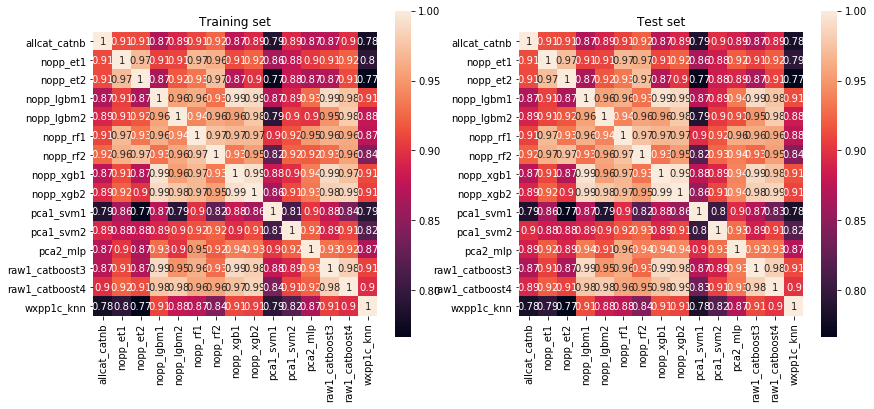

In [49]:
corr_alltrain = allp_alltrain.corr(method='pearson')
corr_test = allp_test.corr(method='pearson')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
sns.heatmap(corr_alltrain, square=True, annot=True, ax=ax1)
sns.heatmap(corr_test, square=True, annot=True, ax=ax2)
ax1.set_title("Training set")
ax2.set_title("Test set")
plt.show()

### Evaluation: Wrongly classified samples

In [85]:
allypred_alltrain = getPredictions(allp_alltrain)

#### Samples classified incorrectly by all models

In [88]:
# ## Not a single one of the model gets it correct
ypred_prod = allypred_alltrain.apply(np.prod, axis=1)
ypred_sum = allypred_alltrain.apply(np.sum, axis=1)

allwrong_0 = allypred_alltrain.loc[(ypred_prod == 1) & (y_alltrain == 0),:]
allwrong_1 = allypred_alltrain.loc[(ypred_sum == 0) & (y_alltrain == 1),:]
print(allwrong_0.shape[0])
print(allwrong_1.shape[0])

436
519


### Pairwise averaging

In [69]:
p_alltrain1 = allp_alltrain.nopp_lgbm1
p_alltrain2 = allp_alltrain.nopp_lgbm2

avg_lgbm = (p_alltrain1 + p_alltrain2)/2
ypred_alltrain = (avg_lgbm > 0.5).astype(int)

print(confusion_matrix(y_alltrain, ypred_alltrain))
print("Accuracy = {:.5f}, F1 = {:.5f}".format(
    accuracy_score(y_alltrain, ypred_alltrain),
    f1_score(y_alltrain, ypred_alltrain)))

[[16521  2039]
 [ 1327  4534]]
Accuracy = 0.86217, F1 = 0.72929


In [70]:
p_alltrain1 = allp_alltrain.nopp_rf1
p_alltrain2 = allp_alltrain.nopp_rf2

avg_rf = (p_alltrain1 + p_alltrain2)/2
ypred_alltrain = (avg_rf > 0.5).astype(int)

print(confusion_matrix(y_alltrain, ypred_alltrain))
print("Accuracy = {:.5f}, F1 = {:.5f}".format(
    accuracy_score(y_alltrain, ypred_alltrain),
    f1_score(y_alltrain, ypred_alltrain)))

[[16749  1811]
 [ 1618  4243]]
Accuracy = 0.85959, F1 = 0.71221


### Stacking: Hard voting

In [63]:
allypred_alltrain = getPredictions(allp_alltrain)

# Average the predicted labels
voteL1_p_alltrain = allypred_alltrain.mean(axis=1)
voteL1_ypred_alltrain = (voteL1_p_alltrain > 0.5).astype(int)

print("Train set:")
print(classification_report(y_alltrain, voteL1_ypred_alltrain))
print(confusion_matrix(y_alltrain, voteL1_ypred_alltrain))
print("Accuracy = {:.5f}, F1 = {:.5f}".format(
    accuracy_score(y_alltrain, voteL1_ypred_alltrain),
    f1_score(y_alltrain, voteL1_ypred_alltrain)))

Train set:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     18560
           1       0.73      0.69      0.71      5861

    accuracy                           0.86     24421
   macro avg       0.82      0.81      0.81     24421
weighted avg       0.86      0.86      0.86     24421

[[17031  1529]
 [ 1793  4068]]
Accuracy = 0.86397, F1 = 0.71007


In [64]:
# Test set predictions
allypred_test = getPredictions(allp_test)

voteL1_p_test = allypred_test.mean(axis=1)
voteL1_ypred_test = (voteL1_p_test > 0.5).astype(int)
# saveResult(voteL1_ypred_test, "stack1_vote.csv")

### Stacking: Soft averaging

In [65]:
avgL1_p_alltrain = allp_alltrain.mean(axis=1)
avgL1_ypred_alltrain = (avgL1_p_alltrain > 0.5).astype(int)

print("Train set:")
print(classification_report(y_alltrain, avgL1_ypred_alltrain))
print(confusion_matrix(y_alltrain, avgL1_ypred_alltrain))
print("Accuracy = {:.5f}, F1 = {:.5f}".format(
    accuracy_score(y_alltrain, avgL1_ypred_alltrain),
    f1_score(y_alltrain, avgL1_ypred_alltrain)))

Train set:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     18560
           1       0.73      0.71      0.72      5861

    accuracy                           0.87     24421
   macro avg       0.82      0.81      0.81     24421
weighted avg       0.86      0.87      0.86     24421

[[17003  1557]
 [ 1725  4136]]
Accuracy = 0.86561, F1 = 0.71594


In [100]:
# Test set predictions
avgL1_p_test = allp_test.mean(axis=1)
avgL1_ypred_test = (avgL1_p_test > 0.5).astype(int)
saveResult(avgL1_ypred_test, "stack1_avg.csv")

Saved submission file to: dump/submissions/stack1_avg.csv


### Stacking: Logistic Regression

In [19]:
## MODEL 1
params_logreg = {
    "C": 1.0,
    "class_weight": None,
    "solver": "lbfgs"
}
logreg = LogisticRegression(**params_logreg)

runL1Model(logreg, allp_alltrain, y_alltrain)
# saveL1Test(logreg, allp_alltrain, y_alltrain,
#            allp_test, "stack1_logreg1.csv")

Training set
Accuracy = 87.257% +/- 0.075
F1 = 72.346% +/- 0.179
Test set
Accuracy = 87.261% +/- 0.133
F1 = 72.345% +/- 0.483


In [138]:
## MODEL 2 (Class imbalance)
params_logreg = {
    'C': 1.0,
    'class_weight': 'balanced',
    'solver': 'lbfgs'
}
logreg = LogisticRegression(**params_logreg)
runL1Model(logreg, allp_alltrain, y_alltrain)
# saveL1Test(logreg, allp_alltrain, y_alltrain,
#            allp_test, "stack1_logreg2.csv")

Train set:
[[12438  2410]
 [  654  4034]]
Accuracy = 84.31613, F1 = 72.47575
Validation set:
[[3101  611]
 [ 181  992]]
Accuracy = 83.787, F1 = 71.470

Saved submission file to: dump/submissions/stack1_logreg2.csv


### Stacked: MLP

In [8]:
params_mlp = {
    'hidden_layer_sizes': (12,15,18,18,18,18,18,18,18,18,12,12),
    'max_iter': 5000,
    'alpha': 1e-4,
    'solver': 'adam',
    'random_state': RAND_STATE,
    'learning_rate_init': 0.01
}
mlp = MLPClassifier(**params_mlp)

cv_list, p_alltrain1 = runL1ModelCV(mlp, X_alltrain, y_alltrain,
                                    cv_filename="data2_mlp.pkl",
                                    best_threshold=False, )

printCVResults("data2_mlp.pkl")

##########
Fold 0
##########
Train set:
[[13867   981]
 [ 1447  3241]]
Accuracy = 87.572, F1 = 72.750
Validation set:
[[3499  213]
 [ 381  792]]
Accuracy = 87.840, F1 = 72.727
##########
Fold 1
##########
Train set:
[[13774  1074]
 [ 1354  3335]]
Accuracy = 87.572, F1 = 73.313
Validation set:
[[3427  285]
 [ 349  823]]
Accuracy = 87.019, F1 = 72.193
##########
Fold 2
##########
Train set:
[[14000   848]
 [ 1578  3111]]
Accuracy = 87.583, F1 = 71.947
Validation set:
[[3498  214]
 [ 418  754]]
Accuracy = 87.060, F1 = 70.467
##########
Fold 3
##########
Train set:
[[14073   775]
 [ 1647  3042]]
Accuracy = 87.603, F1 = 71.526
Validation set:
[[3502  210]
 [ 412  760]]
Accuracy = 87.265, F1 = 70.962
##########
Fold 4
##########
Train set:
[[13904   944]
 [ 1513  3176]]
Accuracy = 87.424, F1 = 72.108
Validation set:
[[3453  259]
 [ 357  815]]
Accuracy = 87.387, F1 = 72.573
Saving CV predictions to: dump/log/data2_mlp.pkl
Train set:
[[13867   981]
 [ 1447  3241]]
Accuracy = 0.87572, F1 = 0.72

### Stacked: Random Forest

In [20]:
params_model = {
    'n_estimators': 300,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'max_depth': 6,
    'bootstrap': True,
    'max_samples': 0.9,
    'n_jobs': -1,
    'random_state': RAND_STATE
}
rf = RandomForestClassifier(**params_model)

cv_list, p_alltrain_rf, p_test_rf = runL1ModelCV(rf, X_alltrain, y_alltrain, X_test,
                                                 cv_filename="stack2_rf_trial.pkl",
                                                 submission_filename='stack2_rf_trial.csv',
                                                 best_threshold=False)

printCVResults("stack2_rf_trial.pkl")

##########
Fold 0
##########
Train set:
[[14017   831]
 [ 1490  3198]]
Accuracy = 88.119, F1 = 73.374
Validation set:
[[3494  218]
 [ 395  778]]
Accuracy = 87.451, F1 = 71.738
##########
Fold 1
##########
Train set:
[[14026   822]
 [ 1565  3124]]
Accuracy = 87.782, F1 = 72.357
Validation set:
[[3488  224]
 [ 356  816]]
Accuracy = 88.124, F1 = 73.779
##########
Fold 2
##########
Train set:
[[14049   799]
 [ 1533  3156]]
Accuracy = 88.064, F1 = 73.022
Validation set:
[[3493  219]
 [ 403  769]]
Accuracy = 87.265, F1 = 71.204
##########
Fold 3
##########
Train set:
[[14037   811]
 [ 1537  3152]]
Accuracy = 87.982, F1 = 72.862
Validation set:
[[3505  207]
 [ 401  771]]
Accuracy = 87.551, F1 = 71.721
##########
Fold 4
##########
Train set:
[[14039   809]
 [ 1500  3189]]
Accuracy = 88.181, F1 = 73.420
Validation set:
[[3497  215]
 [ 428  744]]
Accuracy = 86.835, F1 = 69.826
Predictions:
Saved submission file to: dump/submissions/stack2_rf_trial.csv
Saving CV predictions to: dump/log/stack2_rf

In [90]:
avg_rf = (p_alltrain1 + p_alltrain2)/2
ypred_alltrain = (avg_rf > 0.5).astype(int)

print(confusion_matrix(y_alltrain, ypred_alltrain))
print("Accuracy = {:.5f}, F1 = {:.5f}".format(
    accuracy_score(y_alltrain, ypred_alltrain),
    f1_score(y_alltrain, ypred_alltrain)))

[[16794  1766]
 [ 1490  4371]]
Accuracy = 0.86667, F1 = 0.72862


In [64]:
## LOAD PARAMS
PARAMS_RPATH = 'stack2_rf.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_depth': 8}
Training accuracy: 89.185 +/- 0.143%
Validation accuracy: 87.486 +/- 0.344%

Best params (F1): {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_depth': 8}
Training F1: 75.658 +/- 0.416%
Validation F1: 71.839 +/- 1.040%
Training accuracy: 89.185 +/- 0.143%
Validation accuracy: 87.486 +/- 0.344%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'n_estimators': 50, 'min_samples_split': 2, '...",296,0.880584,0.873797,0.731405,0.715652
1,"{'n_estimators': 100, 'min_samples_split': 2, ...",246,0.880554,0.873920,0.731135,0.716133
2,"{'n_estimators': 300, 'min_samples_split': 2, ...",255,0.880584,0.873920,0.730669,0.715419
3,"{'n_estimators': 500, 'min_samples_split': 2, ...",94,0.880584,0.874289,0.730719,0.716395
4,"{'n_estimators': 2500, 'min_samples_split': 2,...",405,0.880349,0.873551,0.730585,0.715180
...,...,...,...,...,...,...
805,"{'n_estimators': 100, 'min_samples_split': 4, ...",596,0.976731,0.871259,0.949794,0.711131
806,"{'n_estimators': 300, 'min_samples_split': 4, ...",495,0.977642,0.871914,0.951770,0.713004
807,"{'n_estimators': 500, 'min_samples_split': 4, ...",488,0.977929,0.872159,0.952398,0.713602
808,"{'n_estimators': 2500, 'min_samples_split': 4,...",501,0.977908,0.871914,0.952331,0.712901


In [66]:
## INSTANTIATE MODEL
params_rf = {
    'bootstrap': True,
    'n_jobs': -1,
    'class_weight': None,
    'random_state': RAND_STATE
}

params_rf.update(params_acc) # Append best params
for parameter, value in params_rf.items():
    print(parameter, "=", value)

rf = RandomForestClassifier(**params_rf)

cv_list, p_alltrain_rf, p_test_rf = runL1ModelCV(rf, X_alltrain, y_alltrain, X_test,
                                                 cv_filename='stack2_rf.pkl',
                                                 submission_filename='stack2_rf.csv')

printCVResults('stack2_rf.pkl')

bootstrap = True
n_jobs = -1
class_weight = None
random_state = 0
n_estimators = 500
min_samples_split = 2
min_samples_leaf = 1
max_samples = 0.9
max_depth = 8
##########
Fold 0
##########
Train set:
[[14132   716]
 [ 1360  3328]]
Accuracy = 89.373, F1 = 76.225
Validation set:
[[3488  224]
 [ 391  782]]
Accuracy = 87.410, F1 = 71.776
##########
Fold 1
##########
Train set:
[[14140   708]
 [ 1450  3239]]
Accuracy = 88.954, F1 = 75.012
Validation set:
[[3487  225]
 [ 358  814]]
Accuracy = 88.063, F1 = 73.632
##########
Fold 2
##########
Train set:
[[14151   697]
 [ 1424  3265]]
Accuracy = 89.144, F1 = 75.483
Validation set:
[[3493  219]
 [ 403  769]]
Accuracy = 87.265, F1 = 71.204
##########
Fold 3
##########
Train set:
[[14136   712]
 [ 1406  3283]]
Accuracy = 89.159, F1 = 75.610
Validation set:
[[3501  211]
 [ 393  779]]
Accuracy = 87.633, F1 = 72.063
##########
Fold 4
##########
Train set:
[[14140   708]
 [ 1384  3305]]
Accuracy = 89.292, F1 = 75.960
Validation set:
[[3496  216]
 [ 41

### Stacked: ExtraTrees

In [14]:
params_et = {
    'n_estimators': 10000,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'max_depth': 8,
    'max_leaf_nodes': 20,
    'bootstrap': True,
    'max_samples': 0.8,
    'n_jobs': -1,
    'random_state': RAND_STATE
    # 'class_weight': 'balanced_subsample'
}
et = ExtraTreesClassifier(**params_et)

runL1Model(et, allp_alltrain, y_alltrain)
# saveL1Test(et, allp_alltrain, y_alltrain,
#            allp_test, "stack1_et1.csv")

Training set
Accuracy = 87.538% +/- 0.074
F1 = 71.946% +/- 0.295
Test set
Accuracy = 87.367% +/- 0.260
F1 = 71.525% +/- 0.968


### Stacked: XGBoost

In [22]:
params_xgb = {
    'booster': 'gbtree',
    'num_iterations': 50, # aka n_estimators  
    'learning_rate': 0.01, # aka eta
    'max_depth': 6,
    'min_child_weight': 3, # similar to no. of samples in leaf
    'gamma': 6, # larger -> more conservative; default=6
    'subsample': 0.9,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'scale_pos_weight': 1,
    'n_jobs': -1
}
xgb = XGBClassifier(**params_xgb)
cv_list, p_alltrain_xgb = runL1ModelCV(xgb, X_alltrain, y_alltrain,
                                       cv_filename="stack2_xgb_trial.pkl",
                                       best_threshold=False)
printCVResults("stack2_xgb_trial.pkl")

##########
Fold 0
##########
Train set:
[[14066   782]
 [ 1435  3253]]
Accuracy = 88.652, F1 = 74.584
Validation set:
[[3484  228]
 [ 394  779]]
Accuracy = 87.267, F1 = 71.468
##########
Fold 1
##########
Train set:
[[14073   775]
 [ 1537  3152]]
Accuracy = 88.166, F1 = 73.166
Validation set:
[[3491  221]
 [ 361  811]]
Accuracy = 88.084, F1 = 73.593
##########
Fold 2
##########
Train set:
[[14094   754]
 [ 1515  3174]]
Accuracy = 88.386, F1 = 73.668
Validation set:
[[3499  213]
 [ 413  759]]
Accuracy = 87.183, F1 = 70.802
##########
Fold 3
##########
Train set:
[[14084   764]
 [ 1502  3187]]
Accuracy = 88.401, F1 = 73.773
Validation set:
[[3506  206]
 [ 405  767]]
Accuracy = 87.490, F1 = 71.515
##########
Fold 4
##########
Train set:
[[14110   738]
 [ 1507  3182]]
Accuracy = 88.509, F1 = 73.923
Validation set:
[[3505  207]
 [ 441  731]]
Accuracy = 86.732, F1 = 69.289
Saving CV predictions to: dump/log/stack2_xgb_trial.pkl

Train set:
[[14066   782]
 [ 1435  3253]]
Accuracy = 0.88652, F

In [ ]:
## GRID SEARCH
# Fixed parameters
params_xgb = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'random_seed': RAND_STATE
}
xgb = XGBClassifier(**params_xgb)

# Search grid
params_grid = {
    'iterations': [30, 50, 100, 250],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [6, 8, 10],
    'subsample': [0.9, 1.0],
    'min_child_weight': [1, 2, 3],
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 216,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

# # Fit parameters
# params_fit = {
#     'cat_features': list(range(4,11)),
#     'verbose': 100
# }

results_dict = runRandSearchCV(xgb, params_grid, params_search,
                               X_alltrain, y_alltrain,
                               "stack2_xgb.pkl")

216
Number of all possible combinations: 216
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min


In [80]:
## LOAD PARAMS
PARAMS_RPATH = 'stack2_xgb.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'subsample': 1.0, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1, 'iterations': 30}
Training accuracy: 89.436 +/- 0.157%
Validation accuracy: 87.355 +/- 0.426%

Best params (F1): {'subsample': 1.0, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1, 'iterations': 30}
Training F1: 76.241 +/- 0.380%
Validation F1: 71.444 +/- 1.303%
Training accuracy: 89.436 +/- 0.157%
Validation accuracy: 87.355 +/- 0.426%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'subsample': 0.9, 'min_child_weight': 1, 'max...",73,0.885314,0.871545,0.742854,0.711192
1,"{'subsample': 1.0, 'min_child_weight': 1, 'max...",153,0.883266,0.869784,0.739680,0.709572
2,"{'subsample': 0.9, 'min_child_weight': 2, 'max...",61,0.884638,0.871791,0.741363,0.712172
3,"{'subsample': 1.0, 'min_child_weight': 2, 'max...",141,0.882918,0.870071,0.738717,0.710180
4,"{'subsample': 0.9, 'min_child_weight': 3, 'max...",57,0.884259,0.871914,0.740635,0.712630
...,...,...,...,...,...,...
211,"{'subsample': 1.0, 'min_child_weight': 1, 'max...",133,0.964109,0.870685,0.921484,0.709310
212,"{'subsample': 0.9, 'min_child_weight': 2, 'max...",125,0.961959,0.870808,0.916604,0.710280
213,"{'subsample': 1.0, 'min_child_weight': 2, 'max...",161,0.954394,0.869580,0.899321,0.707778
214,"{'subsample': 0.9, 'min_child_weight': 3, 'max...",181,0.954005,0.868802,0.898413,0.706713


In [81]:
## INSTANTIATE MODEL
params_xgb = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'random_seed': RAND_STATE
}

params_xgb.update(params_acc) # Append best params
for parameter, value in params_xgb.items():
    print(parameter, "=", value)

xgb = XGBClassifier(**params_xgb)

cv_list, p_alltrain_xgb, p_test_xgb = runL1ModelCV(xgb, X_alltrain, y_alltrain, X_test,
                                                 cv_filename='stack2_xgb.pkl',
                                                 submission_filename='stack2_xgb.csv')

printCVResults('stack2_xgb.pkl')

booster = gbtree
objective = binary:logistic
random_seed = 0
subsample = 1.0
min_child_weight = 2
max_depth = 6
learning_rate = 0.1
iterations = 30
##########
Fold 0
##########
Train set:
[[14154   694]
 [ 1348  3340]]
Accuracy = 89.548, F1 = 76.588
Validation set:
[[3488  224]
 [ 397  776]]
Accuracy = 87.288, F1 = 71.422
##########
Fold 1
##########
Train set:
[[14145   703]
 [ 1406  3283]]
Accuracy = 89.205, F1 = 75.689
Validation set:
[[3489  223]
 [ 355  817]]
Accuracy = 88.165, F1 = 73.870
##########
Fold 2
##########
Train set:
[[14192   656]
 [ 1397  3292]]
Accuracy = 89.492, F1 = 76.230
Validation set:
[[3493  219]
 [ 413  759]]
Accuracy = 87.060, F1 = 70.605
##########
Fold 3
##########
Train set:
[[14144   704]
 [ 1385  3304]]
Accuracy = 89.307, F1 = 75.980
Validation set:
[[3496  216]
 [ 404  768]]
Accuracy = 87.305, F1 = 71.243
##########
Fold 4
##########
Train set:
[[14173   675]
 [ 1351  3338]]
Accuracy = 89.630, F1 = 76.718
Validation set:
[[3501  211]
 [ 426  746]]
Acc

### Stacked: LGBM

In [34]:
params_lgbm = {
    'max_depth': 6,
#     'learning_rate': 0.1, # Increase n_estimators when reducing learning rate
    'n_estimators': 80,
#     'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'min_data_in_leaf': 2,
    'bagging_freq': 4,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.9,
    'random_state': RAND_STATE
    # 'scale_pos_weight': 3
}
lgbm = lgb.LGBMClassifier(**params_lgbm)

print(list(X_alltrain))

cv_list, p_alltrain = runL1ModelCV(lgbm, X_alltrain, y_alltrain,
                                   cv_filename="stack2_lgbm_trial.pkl",
                                   best_threshold=False,
                                   verbose=100)

printCVResults("stack2_lgbm_trial.pkl")

['allcat_catnb', 'nopp_et1', 'nopp_et2', 'nopp_lgbm1', 'nopp_lgbm2', 'nopp_rf1', 'nopp_rf2', 'nopp_xgb1', 'nopp_xgb2', 'pca1_svm1', 'pca1_svm2', 'pca2_mlp', 'raw1_catboost3', 'raw1_catboost4', 'wxpp1c_knn', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
##########
Fold 0
##########
Train set:
[[14173   675]
 [ 1291  3397]]
Accuracy = 89.937, F1 = 77.557
Validation set:
[[3481  231]
 [ 405  768]]
Accuracy = 86.981, F1 = 70.718
##########
Fold 1
##########
Train set:
[[14148   700]
 [ 1388  3301]]
Accuracy = 89.313, F1 = 75.972
Validation set:
[[3483  229]
 [ 359  813]]
Accuracy = 87.961, F1 = 73.442
##########
Fold 2
##########
Train set:
[[14163   685]
 [ 1337  3352]]
Accuracy = 89.650, F1 = 76.828
Validation set:
[[3490  222]
 [ 409  763]]
Accuracy = 87.080, F1 = 70.746
##########
Fold 3
##########
Train set:
[[14123   725]
 [ 1342  3347]]
Accuracy = 89.420, F1 = 76.407
Validation set:
[[3492  220]
 [ 400  772]]
Accuracy = 87.305, F1 = 71.349
##########
Fold 4


In [ ]:
## GRID SEARCH
# Fixed parameters
params_lgbm = {
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'bootstrap': True,
    'n_jobs': -1,
    'random_seed': RAND_STATE
}
lgbm = lgb.LGBMClassifier(**params_lgbm)

# Search grid
params_grid = {
    'iterations': [30, 50, 100, 250, 500, 750],
    'max_depth': [6, 8, 10, 12],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1, 10]
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 864,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

# # # Fit parameters
# # params_fit = {
# #     'cat_features': list(range(4,11)),
# #     'verbose': 100
# # }

print(list(X_alltrain))

results_dict = runRandSearchCV(lgbm, params_grid, params_search,
                               X_alltrain, y_alltrain,
                               "stack2_lgbm.pkl")

864
['allcat_catnb', 'nopp_et1', 'nopp_et2', 'nopp_lgbm1', 'nopp_lgbm2', 'nopp_rf1', 'nopp_rf2', 'nopp_xgb1', 'nopp_xgb2', 'pca1_svm1', 'pca1_svm2', 'pca2_mlp', 'raw1_catboost3', 'raw1_catboost4', 'wxpp1c_knn', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
Number of all possible combinations: 864
Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  5.6min


In [69]:
## LOAD PARAMS
PARAMS_RPATH = 'stack2_lgbm.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 6, 'iterations': 30, 'bagging_fraction': 0.8}
Training accuracy: 89.506 +/- 0.164%
Validation accuracy: 87.335 +/- 0.508%

Best params (F1): {'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth': 6, 'iterations': 30, 'bagging_fraction': 0.8}
Training F1: 77.189 +/- 0.486%
Validation F1: 71.504 +/- 1.624%
Training accuracy: 89.806 +/- 0.225%
Validation accuracy: 87.322 +/- 0.583%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'reg_lambda': 0, 'reg_alpha': 0, 'max_depth':...",109,0.897261,0.872692,0.770308,0.713256
1,"{'reg_lambda': 0.1, 'reg_alpha': 0, 'max_depth...",199,0.896708,0.872446,0.768469,0.713335
2,"{'reg_lambda': 1, 'reg_alpha': 0, 'max_depth':...",181,0.894886,0.872610,0.763665,0.713040
3,"{'reg_lambda': 10, 'reg_alpha': 0, 'max_depth'...",19,0.888160,0.873306,0.748258,0.714392
4,"{'reg_lambda': 0, 'reg_alpha': 0.1, 'max_depth...",37,0.898059,0.873224,0.771890,0.715039
...,...,...,...,...,...,...
859,"{'reg_lambda': 10, 'reg_alpha': 0.1, 'max_dept...",541,0.929282,0.869743,0.843906,0.708662
860,"{'reg_lambda': 0, 'reg_alpha': 1, 'max_depth':...",775,0.973783,0.868105,0.943912,0.705426
861,"{'reg_lambda': 0.1, 'reg_alpha': 1, 'max_depth...",847,0.972186,0.867041,0.940256,0.703079
862,"{'reg_lambda': 1, 'reg_alpha': 1, 'max_depth':...",829,0.962123,0.867368,0.918255,0.703560


In [70]:
## INSTANTIATE MODEL
params_lgbm = {
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'bootstrap': True,
    'n_jobs': -1,
    'random_seed': RAND_STATE
}


params_lgbm.update(params_acc) # Append best params
for parameter, value in params_lgbm.items():
    print(parameter, "=", value)

lgbm = lgb.LGBMClassifier(**params_lgbm)

cv_list, p_alltrain_lgbm, p_test_lgbm = runL1ModelCV(lgbm, X_alltrain, y_alltrain, X_test,
                                                     cv_filename='stack2_lgbm.pkl',
                                                     submission_filename='stack2_lgbm.csv',
                                                     verbose=100)

printCVResults("stack2_lgbm.pkl")

boosting_type = gbdt
num_leaves = 100
bootstrap = True
n_jobs = -1
random_seed = 0
reg_lambda = 1
reg_alpha = 0.1
max_depth = 6
iterations = 30
bagging_fraction = 0.8
##########
Fold 0
##########
Train set:
[[14188   660]
 [ 1331  3357]]
Accuracy = 89.809, F1 = 77.128
Validation set:
[[3495  217]
 [ 406  767]]
Accuracy = 87.247, F1 = 71.117
##########
Fold 1
##########
Train set:
[[14179   669]
 [ 1399  3290]]
Accuracy = 89.415, F1 = 76.087
Validation set:
[[3490  222]
 [ 353  819]]
Accuracy = 88.227, F1 = 74.017
##########
Fold 2
##########
Train set:
[[14174   674]
 [ 1372  3317]]
Accuracy = 89.528, F1 = 76.429
Validation set:
[[3488  224]
 [ 407  765]]
Accuracy = 87.080, F1 = 70.801
##########
Fold 3
##########
Train set:
[[14153   695]
 [ 1390  3299]]
Accuracy = 89.328, F1 = 75.988
Validation set:
[[3498  214]
 [ 400  772]]
Accuracy = 87.428, F1 = 71.548
##########
Fold 4
##########
Train set:
[[14139   709]
 [ 1352  3337]]
Accuracy = 89.451, F1 = 76.405
Validation set:
[[3492  220

### Model: CatBoost

In [84]:
Xsub_alltrain = X_alltrain.drop(['nopp_xgb1','nopp_xgb2'], axis=1)
Xsub_test = X_test.drop(['nopp_xgb1','nopp_xgb2'], axis=1)

In [85]:
## FROM FIRST SEARCH
params_catboost = {
    'iterations': 60, # n_estimators
    'depth': 6,
    'l2_leaf_reg': 2,
    'scale_pos_weight': 1.0,
    'random_seed': RAND_STATE
}

catboost = CatBoostClassifier(**params_catboost)

print(list(X_alltrain))

cv_list, p_alltrain, p_test = runL1ModelCV(catboost, Xsub_alltrain, y_alltrain, Xsub_test,
                                           cv_filename="stack2_catboost_trial.pkl",
                                   best_threshold=False,
                                   verbose=100)

printCVResults("stack2_catboost_trial.pkl")

['allcat_catnb', 'nopp_et1', 'nopp_et2', 'nopp_lgbm1', 'nopp_lgbm2', 'nopp_rf1', 'nopp_rf2', 'nopp_xgb1', 'nopp_xgb2', 'pca1_svm1', 'pca1_svm2', 'pca2_mlp', 'raw1_catboost3', 'raw1_catboost4', 'wxpp1c_knn', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
##########
Fold 0
##########
0:	learn: 0.6566065	total: 41ms	remaining: 2.42s
59:	learn: 0.2796401	total: 2.63s	remaining: 0us
Train set:
[[13979   869]
 [ 1528  3160]]
Accuracy = 87.730, F1 = 72.502
Validation set:
[[3493  219]
 [ 390  783]]
Accuracy = 87.533, F1 = 72.000
##########
Fold 1
##########
0:	learn: 0.6570803	total: 46ms	remaining: 2.71s
59:	learn: 0.2846774	total: 2.87s	remaining: 0us
Train set:
[[13992   856]
 [ 1595  3094]]
Accuracy = 87.455, F1 = 71.629
Validation set:
[[3493  219]
 [ 355  817]]
Accuracy = 88.247, F1 = 74.004
##########
Fold 2
##########
0:	learn: 0.6560710	total: 55.6ms	remaining: 3.28s
59:	learn: 0.2810635	total: 3s	remaining: 0us
Train set:
[[14041   807]
 [ 1593  3096]]
Accura

In [87]:
## FROM FIRST SEARCH
params_catboost = {
    'iterations': 60, # n_estimators
    'depth': 6,
    'l2_leaf_reg': 3,
    'scale_pos_weight': 1.0,
    'random_seed': RAND_STATE
}

catboost = CatBoostClassifier(**params_catboost)

print(list(X_alltrain))

cv_list, p_alltrain, p_test = runL1ModelCV(catboost, X_alltrain, y_alltrain, X_test,
                                           cv_filename="stack2_catboost_trial.pkl",
#                                    submission_filename='stack2_catboost_trial.pkl',
                                   best_threshold=False,
                                   verbose=100)

printCVResults("stack2_catboost_trial.pkl")

['allcat_catnb', 'nopp_et1', 'nopp_et2', 'nopp_lgbm1', 'nopp_lgbm2', 'nopp_rf1', 'nopp_rf2', 'nopp_xgb1', 'nopp_xgb2', 'pca1_svm1', 'pca1_svm2', 'pca2_mlp', 'raw1_catboost3', 'raw1_catboost4', 'wxpp1c_knn', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
##########
Fold 0
##########
0:	learn: 0.6611831	total: 51.1ms	remaining: 3.01s
59:	learn: 0.2793361	total: 2.83s	remaining: 0us
Train set:
[[13983   865]
 [ 1545  3143]]
Accuracy = 87.664, F1 = 72.286
Validation set:
[[3493  219]
 [ 391  782]]
Accuracy = 87.513, F1 = 71.941
##########
Fold 1
##########
0:	learn: 0.6574815	total: 41.5ms	remaining: 2.45s
59:	learn: 0.2842712	total: 2.71s	remaining: 0us
Train set:
[[13982   866]
 [ 1588  3101]]
Accuracy = 87.439, F1 = 71.650
Validation set:
[[3485  227]
 [ 355  817]]
Accuracy = 88.084, F1 = 73.736
##########
Fold 2
##########
0:	learn: 0.6612931	total: 45.2ms	remaining: 2.67s
59:	learn: 0.2814628	total: 2.78s	remaining: 0us
Train set:
[[14028   820]
 [ 1591  3098]]

In [ ]:
## GRID SEARCH
# Fixed parameters
params_catboost = {
    'random_seed': RAND_STATE
}
catboost = CatBoostClassifier(**params_catboost)

# Search grid
params_grid = {
    'iterations': [30, 50, 100, 250, 500],
    'depth': [4, 6, 8, 10],
    'grow_policy': ['SymmetricTree', 'Depthwise'],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 1, 5],
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 360,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

# Fit parameters
params_fit = {
    'verbose': 100
}

print(list(X_alltrain))

results_dict = runRandSearchCV(catboost, params_grid, params_search,
                               X_alltrain, y_alltrain,
                               "stack2_catboost.pkl", params_fit=params_fit)

360
['allcat_catnb', 'nopp_et1', 'nopp_et2', 'nopp_lgbm1', 'nopp_lgbm2', 'nopp_rf1', 'nopp_rf2', 'nopp_xgb1', 'nopp_xgb2', 'pca1_svm1', 'pca1_svm2', 'pca2_mlp', 'raw1_catboost3', 'raw1_catboost4', 'wxpp1c_knn', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
Number of all possible combinations: 360
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.9s


In [72]:
## LOAD PARAMS
PARAMS_RPATH = 'stack2_catboost.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'l2_leaf_reg': 1, 'iterations': 30, 'grow_policy': 'Depthwise', 'depth': 4, 'bagging_temperature': 0}
Training accuracy: 87.567 +/- 0.097%
Validation accuracy: 87.478 +/- 0.469%

Best params (F1): {'l2_leaf_reg': 5, 'iterations': 30, 'grow_policy': 'SymmetricTree', 'depth': 4, 'bagging_temperature': 0}
Training F1: 72.056 +/- 0.373%
Validation F1: 72.002 +/- 1.153%
Training accuracy: 87.478 +/- 0.122%
Validation accuracy: 87.453 +/- 0.400%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'l2_leaf_reg': 1, 'iterations': 30, 'grow_pol...",28,0.874770,0.874534,0.719930,0.719156
1,"{'l2_leaf_reg': 3, 'iterations': 30, 'grow_pol...",64,0.874596,0.874207,0.718954,0.718394
2,"{'l2_leaf_reg': 5, 'iterations': 30, 'grow_pol...",25,0.874780,0.874534,0.720563,0.720016
3,"{'l2_leaf_reg': 1, 'iterations': 50, 'grow_pol...",31,0.875179,0.874493,0.719251,0.717529
4,"{'l2_leaf_reg': 3, 'iterations': 50, 'grow_pol...",124,0.874862,0.873961,0.717604,0.715919
...,...,...,...,...,...,...
355,"{'l2_leaf_reg': 3, 'iterations': 250, 'grow_po...",346,0.968163,0.869129,0.930777,0.708114
356,"{'l2_leaf_reg': 5, 'iterations': 250, 'grow_po...",331,0.961990,0.870481,0.916788,0.709477
357,"{'l2_leaf_reg': 1, 'iterations': 500, 'grow_po...",358,0.999509,0.867532,0.998975,0.704801
358,"{'l2_leaf_reg': 3, 'iterations': 500, 'grow_po...",352,0.996294,0.867983,0.992222,0.706445


In [79]:
## INSTANTIATE MODEL
params_catboost = {
    'random_seed': 0
}

params_catboost.update(params_acc) # Append best params
for parameter, value in params_catboost.items():
    print(parameter, "=", value)

catboost = CatBoostClassifier(**params_catboost)

cv_list, p_alltrain_catboost, p_test_catboost = runL1ModelCV(catboost, X_alltrain, y_alltrain, X_test,
                                                             cv_filename="stack2_catboost.pkl",
#                                                              submission_filename='stack2_catboost.csv',
                                                             random_state=2,
                                                             best_threshold=False,
                                                             verbose=100)

printCVResults("stack2_catboost.pkl")

random_seed = 0
l2_leaf_reg = 1
iterations = 30
grow_policy = Depthwise
depth = 4
bagging_temperature = 0
##########
Fold 0
##########
0:	learn: 0.6525677	total: 53.6ms	remaining: 1.55s
29:	learn: 0.3154607	total: 1.72s	remaining: 0us
Train set:
[[13960   888]
 [ 1544  3144]]
Accuracy = 87.551, F1 = 72.110
Validation set:
[[3492  220]
 [ 392  781]]
Accuracy = 87.472, F1 = 71.849
##########
Fold 1
##########
0:	learn: 0.6520417	total: 55ms	remaining: 1.59s
29:	learn: 0.3185605	total: 1.74s	remaining: 0us
Train set:
[[14010   838]
 [ 1621  3068]]
Accuracy = 87.414, F1 = 71.390
Validation set:
[[3496  216]
 [ 359  813]]
Accuracy = 88.227, F1 = 73.876
##########
Fold 2
##########
0:	learn: 0.6522908	total: 58.6ms	remaining: 1.7s
29:	learn: 0.3124117	total: 1.74s	remaining: 0us
Train set:
[[14017   831]
 [ 1589  3100]]
Accuracy = 87.613, F1 = 71.926
Validation set:
[[3490  222]
 [ 400  772]]
Accuracy = 87.265, F1 = 71.283
##########
Fold 3
##########
0:	learn: 0.6527399	total: 56.4ms	remain